In [18]:
%reload_ext autoreload
%autoreload 2

In [19]:
from fastai.vision import conv_layer
from fastai.vision.data import SegmentationLabelList, SegmentationProcessor, SegmentationItemList
from fastai.vision.transform import get_transforms
from fastai.vision.image import open_image, open_mask, Image
from pathlib import Path
from torch import nn

from spadedata import SpadeItemList

In [20]:
import fastai
print(fastai.__file__)

C:\ProgramData\Anaconda3\envs\pytorch100\lib\site-packages\fastai\__init__.py


In [21]:
path = Path(r'D:\data\landcover\landcover')
batch_size = 8

In [22]:
codes = ['NoData', 'Water', 'Wetlands', 'Tree1', 'Shurbland', 'Lowvegetation', 'Barren', 'Structures', 'Impervious',
       'Roads', 'Tree2', 'Tree3', 'Tree4']

In [23]:
 def get_y_func(x, ext='tif'):
    return x.parents[1] / 'images' / (x.stem + '.{}'.format(ext))

In [24]:
# class SpadeProcessor(SegmentationProcessor):
#     "`PreProcessor` that stores the classes for segmentation."
#     def __init__(self, ds):
#         self.classes = ds.classes
        
#     def process(self, ds):
#         ds.classes,ds.c = self.classes,len(self.classes)

# class SpadeLabelList(SegmentationLabelList):
#     "`ItemList` for segmentation masks."
#     _processor = SpadeProcessor
#     def __init__(self, items, classes=None, **kwargs):
#         super().__init__(items, **kwargs)
#         self.copy_new.append('classes')
#         self.classes = classes   #  loss function to be added

#     def open(self, fn, **kwargs):
#         return open_image(fn, **kwargs)
    
#     def analyze_pred(self, pred, thresh:float=0.5):
#         return pred
    
#     def reconstruct(self, t):
#         return Image(t)

# class SpadeItemList(SegmentationLabelList):
#     "`ItemList` suitable for segmentation tasks."
#     _label_cls,_square_show_res = SpadeLabelList, False

## Data Prep

In [27]:
src = (SpadeItemList.from_folder(path/'labels', classes=codes)
      .random_split_by_pct(0.1)
      .label_from_func(get_y_func))

In [28]:
data = (src.transform(get_transforms(), tfm_y=True)
       .databunch(bs=batch_size))

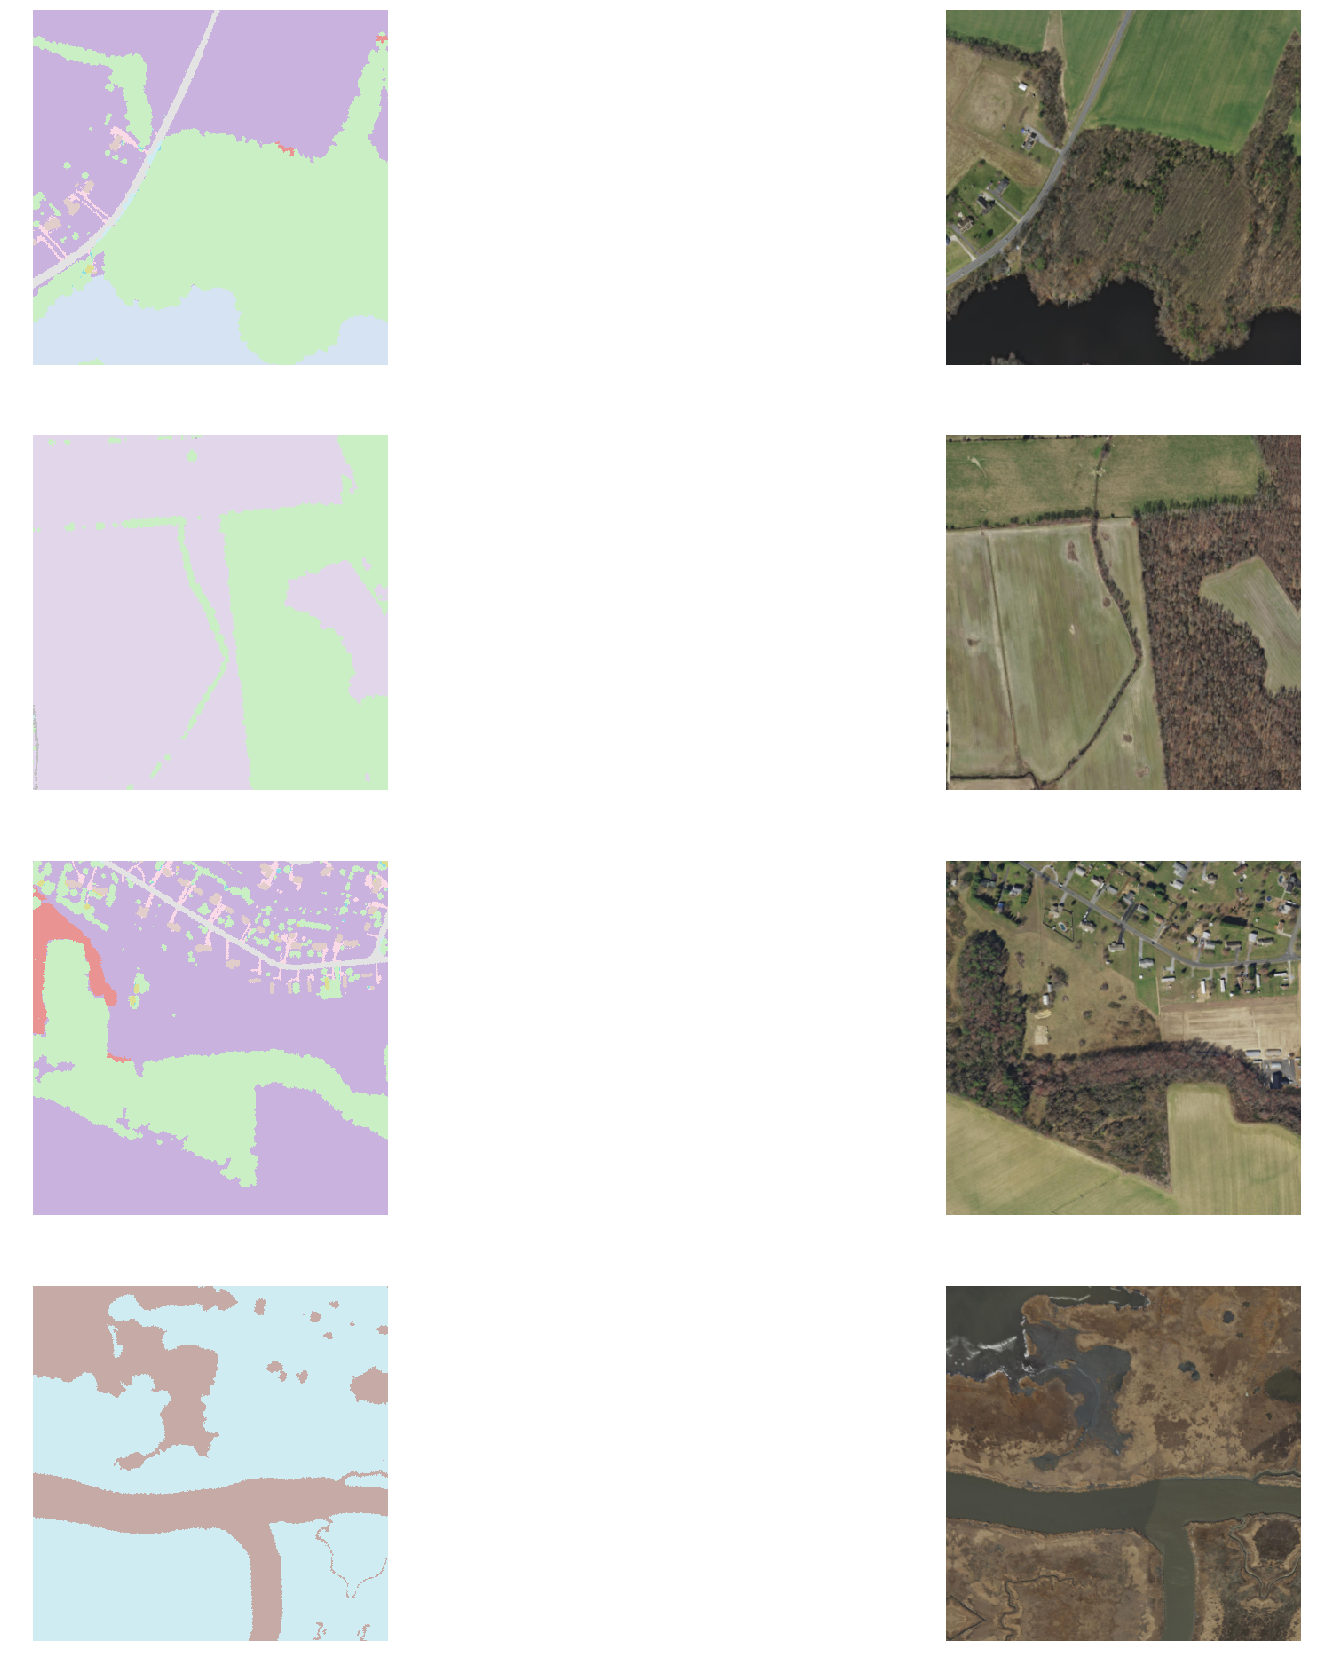

In [39]:
data.show_batch(rows=2)

## Model Architecture

In [64]:
from fastai.vision import ImageSegment, PixelShuffle_ICNR
from fastai.layers import NormType
import torch.nn.functional as F
from torch.nn.utils import spectral_norm
from torch.distributions import Normal
import torch

In [150]:
## check dimension after conv layer
class SpadeBN(nn.Module):
    def __init__(self, nf):
        super(SpadeBN, self).__init__()

        self.bn = nn.BatchNorm2d(nf, affine=False)
        self.conv0 = conv_layer(1, 128, norm_type=NormType.Spectral)  # hardcoded
        self.conv1 = conv_layer(128, nf, norm_type=NormType.Spectral)
        self.conv2 = conv_layer(128, nf, norm_type=NormType.Spectral)
        
    def forward(self, features, mask):
        size = features.size()[-2:]
        mask = mask.resize(size)
        interim_conv = self.conv0(mask)
        gamma = self.conv1(interim_conv)
        beta = self.conv2(interim_conv)
        return (self.bn(features) * gamma) + beta

In [156]:
class SpadeResBlock(nn.Module):
    def __init__(self, ni, nf):
        super(SpadeResBlock, self).__init__()
        self.spade_bn0 = SpadeBN(ni)
        ## can get away with spectral norm by passing NormType.Spectral
        self.conv0 = conv_layer(ni, nf, use_activ=False, norm_type=NormType.Spectral)
        self.spade_bn1 = SpadeBN(nf)
        self.conv1 = conv_layer(nf, nf, use_activ=False, norm_type=NormType.Spectral)
        self.spade_skip = SpadeBN(ni)
        self.conv_skip = conv_layer(ni, nf, use_activ=False, norm_type=NormType.Spectral)
        
    def forward(self, features, mask):
        skip_features = self.conv_skip(F.relu(self.spade_skip(features, mask)))
        features = self.conv0(F.relu(self.spade_bn0(features, mask)))
        features = self.conv1(F.relu(self.spade_bn1(features, mask)))
        return skip_features + features

In [157]:
nfs = [1024,1024,1024,512,256,128,64]
scale = [2] * len(nfs)
input_noise_dim = 256

class SpadeGenerator(nn.Module):
    
    def __init__(self, input_noise_dim=input_noise_dim,
                 nfs=nfs,
                 pixel_shuffle_upsampling=True,
                 batch_size=batch_size,
                 input_image=None):  ## for semantic style, requires different loss functions
        super(SpadeGenerator, self).__init__()
        self.input_noise_dim = input_noise_dim
        self.batch_size = batch_size
        self.linear = nn.Linear(input_noise_dim, 16384)  # hardcoded
        self.spade_upsample_blocks = nn.ModuleList([])
        for i in range(len(nfs)):
            self.spade_upsample_blocks.append(nn.ModuleList([SpadeResBlock(1024, nfs[i]),
                           PixelShuffle_ICNR(nfs[i], nfs[i], scale=2, norm_type=NormType.Spectral) if pixel_shuffle_upsampling else nn.UpsamplingNearest2d(scale=2)]))
        self.conv_final = conv_layer(nfs[-1], 3, use_activ=False, bias=True, norm_type=None)
    
    def forward(self, mask):
        gaussian_noise = Normal(0,1).sample(torch.Size([self.batch_size, self.input_noise_dim]))
        linear_features = self.linear(gaussian_noise)
        spatial_features = linear_features.view(self.batch_size, 1024, 4, 4) # hardcoded
        for block in self.spade_upsample_blocks:
            spatial_features = block[0](spatial_features, mask)
            spatial_features = block[1](spatial_features)
        return F.tanh(self.conv_final(spatial_features))

In [196]:
from fastai.layers import Lambda

In [197]:
def AvgFlatten():
    "Takes the average of the input."
    return Lambda(lambda x: x.mean(0).view(1))

In [208]:
disc_nfs = [64,128,256,512,1]

class SpadeDiscriminator(nn.Module):
    def __init__(self):
        super(SpadeDiscriminator, self).__init__()
        layers = []
        for idx, nf in enumerate(disc_nfs):            
            layers.append(conv_layer(ni=4 if idx == 0 else disc_nfs[idx-1],
                                                   nf=disc_nfs[idx],
                                                   ks=4,
                                                   stride=2,
                                                   bias=True,
                                                   norm_type=NormType.Spectral,
                                                   use_activ=False))
            if idx != 0:
                layers.append(nn.InstanceNorm2d(nf))
                layers.append(nn.LeakyReLU(inplace=True))
            else:
                layers.append(nn.LeakyReLU(inplace=True))
                
                
#         self.conv1 = spectral_norm(conv_layer(ni=64, nf=128, ks=4, stride=2, bias=True, norm_type=None, use_activ=False))
#         self.in1 = nn.InstanceNorm2d(128)
#         self.relu = nn.LeakyReLU(inplace=True)
#         self.conv2 = spectral_norm(conv_layer(ni=128, nf=256, ks=4, stride=2, bias=True, norm_type=None, use_activ=False))
#         self.in2 = nn.InstanceNorm2d(256)
#         self.conv3 = spectral_norm(conv_layer(ni=256, nf=512, ks=4, bias=True, norm_type=None, use_activ=False))
#         self.in3 = nn.InstanceNorm2d(512)
        ### skipping a layer which seems to be a mistake in the paper.
        layers.append(conv_layer(ni=512, nf=1, ks=4, bias=True, norm_type=NormType.Spectral, use_activ=False))
        layers.append(AvgFlatten())
        self.disc = nn.Sequential(*layers)
        
    def forward(self, image, mask):
        torch.cat((image, mask), dim=1)
        return self.disc(concat_image_mask)
        
        
        

In [209]:
from fastai.layers import NoopLoss, Lambda

In [210]:
class disc_loss(nn.Module):
    def forward(self, real, fake):
        return F.relu(1 - real).mean() + F.relu(1 + fake).mean()

In [211]:
from fastai.vision.gan import GANLearner

In [212]:
generator = SpadeGenerator()

In [213]:
discriminator = SpadeDiscriminator()

In [ ]:
class

In [214]:
spadegan = GANLearner(data,
                      generator=generator,
                      critic=discriminator,
                      gen_loss_func=NoopLoss(),
                      crit_loss_func=disc_loss()
                      )

In [215]:
spadegan.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


TypeError: forward() missing 1 required positional argument: 'mask'